Run a group analysis using FSL.  The data are obtained from the Human Connectome Project, and include 32 subjects on a relational matching task (using the Relational - Match contrast).

In [1]:
import os,shutil
from nipype.interfaces import fsl
import nibabel
import numpy
import nilearn.plotting

%matplotlib inline

import matplotlib.pyplot as plt
try:
    datadir=os.environ['FMRIDATADIR']
    assert not datadir==''
except:
    datadir='/Users/poldrack/data_unsynced/myconnectome/sub00001'

basedir=os.path.join(datadir,'ds009')
notebook_base= os.path.abspath(".")
cope='cope001_go'
results_dir = os.path.abspath("../results")

if not os.path.exists(results_dir):
    os.mkdir(results_dir)

from nipype.caching import Memory
mem = Memory(base_dir='.')

copefile=os.path.join(basedir,'task002_%s.nii.gz'%cope)
varcopefile=os.path.join(basedir,'task002_var%s.nii.gz'%cope)
nsubs=24


First run using OLS.

In [2]:
    
deshdr="""/NumWaves	1
/NumPoints	24
/PPheights		1.000000e+00

/Matrix"""

conhdr="""/ContrastName1	group mean
/NumWaves	1
/NumContrasts	1
/PPheights		1.000000e+00
/RequiredEffect		1.441

/Matrix"""

grouphdr="""/NumWaves	1
/NumPoints	24

/Matrix"""
desmtx=numpy.ones((nsubs,1))
numpy.savetxt('design.mat',desmtx,fmt='%1.0f',header=deshdr,comments='')
numpy.savetxt('covsplit.txt',desmtx,fmt='%1.0f',header=grouphdr,comments='')
conmtx=numpy.ones(1)
numpy.savetxt('design.con',conmtx,fmt='%1.0f',header=conhdr,comments='')

level2=mem.cache(fsl.FLAMEO)
flameo_results = level2(cope_file=copefile, 
                    var_cope_file=varcopefile,
                    design_file='design.mat',
                    cov_split_file='covsplit.txt',
                    t_con_file='design.con',
                    mask_file=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz'),
                    run_mode='ols')

flameo_results.outputs

shutil.move(flameo_results.outputs.stats_dir,os.path.join(results_dir,'stats_OLS'))


161027-03:31:37,629 workflow INFO:
	 Executing node 913218ad962c8ea4475630a4395a2c60 in dir: /home/vagrant/fmri-analysis-vm/analysis/group/nipype_mem/nipype-interfaces-fsl-model-FLAMEO/913218ad962c8ea4475630a4395a2c60
161027-03:31:37,634 workflow INFO:
	 Running: flameo --copefile=/home/vagrant/data/ds009/task002_cope001_go.nii.gz --covsplitfile=/home/vagrant/fmri-analysis-vm/analysis/group/covsplit.txt --designfile=/home/vagrant/fmri-analysis-vm/analysis/group/design.mat --ld=stats --maskfile=/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz --runmode=ols --tcontrastsfile=/home/vagrant/fmri-analysis-vm/analysis/group/design.con --varcopefile=/home/vagrant/data/ds009/task002_varcope001_go.nii.gz
161027-03:31:37,680 interface INFO:
	 stdout 2016-10-27T03:31:37.680374:Log directory is: stats
161027-03:31:37,681 interface INFO:
	 stdout 2016-10-27T03:31:37.680374:Setting up:
161027-03:31:39,229 interface INFO:
	 stdout 2016-10-27T03:31:39.229166:ntptsing=24.000000 
1610

'/home/vagrant/fmri-analysis-vm/analysis/results/stats_OLS/stats'

Estimate smoothness and compute cluster-corrected thresholded map

In [3]:
est = mem.cache(fsl.SmoothEstimate)
smoothness=est(dof=23,
    residual_fit_file = os.path.join(results_dir,'stats_OLS/res4d.nii.gz'),
    mask_file = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz'))

print(smoothness.outputs)

161027-03:31:44,884 workflow INFO:
	 Executing node f8ee249febd84d22d679f695c1d8e79a in dir: /home/vagrant/fmri-analysis-vm/analysis/group/nipype_mem/nipype-interfaces-fsl-model-SmoothEstimate/f8ee249febd84d22d679f695c1d8e79a
161027-03:31:44,887 workflow INFO:

dlh = 0.332522
resels = 14.1541
volume = 223953



161027-03:31:44,936 workflow INFO:
	 Executing node 9d739e6496faf7f1e798aba5c30bb58e in dir: /home/vagrant/fmri-analysis-vm/analysis/group/nipype_mem/nipype-interfaces-fsl-model-Cluster/9d739e6496faf7f1e798aba5c30bb58e
161027-03:31:44,942 workflow INFO:
	 Running: cluster --dlh=0.3325220000 --in=/home/vagrant/fmri-analysis-vm/analysis/results/stats_OLS/zstat1.nii.gz --olmax=/home/vagrant/fmri-analysis-vm/analysis/results/stats_OLS/zstat1_cluster_max.txt --othresh=/home/vagrant/fmri-analysis-vm/analysis/results/stats_OLS/zstat1_thresh.nii.gz --pthresh=0.0500000000 --thresh=2.3000000000 --volume=223953
161027-03:31:45,485 interface INFO:
	 stdout 2016-10-27T03:31:45.485566:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (vox)	MAX Y (vox)	MAX Z (vox)	COG X (vox)	COG Y (vox)	COG Z (vox)
161027-03:31:45,487 interface INFO:
	 stdout 2016-10-27T03:31:45.485566:8	13761	0	113	6.36	58	66	36	52	57.6	53.3
161027-03:31:45,488 interface INFO:
	 stdout 2016-10-27T03:31:45.485566:7	4568	0	52.9	6.6	36	37	26

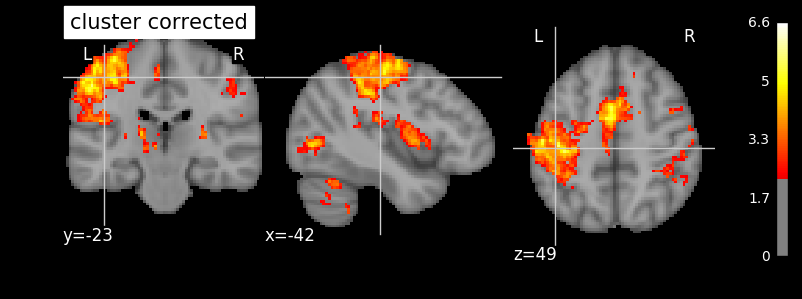

In [4]:
cl = mem.cache(fsl.Cluster)
cluster_results=cl(threshold = 2.3,
   in_file = os.path.join(results_dir,'stats_OLS/zstat1.nii.gz'),
    dlh=smoothness.outputs.dlh,
    volume=smoothness.outputs.volume,
    pthreshold=0.05,
    out_localmax_txt_file=os.path.join(results_dir,'stats_OLS/zstat1_cluster_max.txt'),
    out_threshold_file=os.path.join(results_dir,'stats_OLS/zstat1_thresh.nii.gz'))

with open(os.path.join(results_dir,'stats_OLS/zstat1_cluster_list.txt'),'w') as f:
    f.write(cluster_results.runtime.stdout)

thresh_zstat_OLS=nibabel.load(os.path.join(results_dir,'stats_OLS/zstat1_thresh.nii.gz'))
bgimage=nibabel.load(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'))
map_display=nilearn.plotting.plot_stat_map(thresh_zstat_OLS,bgimage,threshold=2.3,title='cluster corrected')

Run same model using mixed effects with FLAME 1

In [5]:
level2=mem.cache(fsl.FLAMEO)
flameo_results = level2(cope_file=copefile, 
                    var_cope_file=varcopefile,
                    design_file='design.mat',
                    cov_split_file='covsplit.txt',
                    t_con_file='design.con',
                    mask_file=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz'),
                    run_mode='flame1')

flameo_results.outputs

shutil.move(flameo_results.outputs.stats_dir,os.path.join(results_dir,'stats_FLAME1'))



161027-03:31:46,787 workflow INFO:
	 Executing node 2e8a27f99362913d008328e2b78349f8 in dir: /home/vagrant/fmri-analysis-vm/analysis/group/nipype_mem/nipype-interfaces-fsl-model-FLAMEO/2e8a27f99362913d008328e2b78349f8
161027-03:31:46,792 workflow INFO:
	 Running: flameo --copefile=/home/vagrant/data/ds009/task002_cope001_go.nii.gz --covsplitfile=/home/vagrant/fmri-analysis-vm/analysis/group/covsplit.txt --designfile=/home/vagrant/fmri-analysis-vm/analysis/group/design.mat --ld=stats --maskfile=/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz --runmode=flame1 --tcontrastsfile=/home/vagrant/fmri-analysis-vm/analysis/group/design.con --varcopefile=/home/vagrant/data/ds009/task002_varcope001_go.nii.gz
161027-03:31:46,826 interface INFO:
	 stdout 2016-10-27T03:31:46.826848:Log directory is: stats
161027-03:31:47,329 interface INFO:
	 stdout 2016-10-27T03:31:47.329891:Setting up:
161027-03:31:47,832 interface INFO:
	 stdout 2016-10-27T03:31:47.832402:ntptsing=24.000000 
1

'/home/vagrant/fmri-analysis-vm/analysis/results/stats_FLAME1/stats'

Run fixed effects model for comparison

In [6]:
level2=mem.cache(fsl.FLAMEO)
flameo_results = level2(cope_file=copefile, 
                    var_cope_file=varcopefile,
                    design_file='design.mat',
                    cov_split_file='covsplit.txt',
                    t_con_file='design.con',
                    mask_file=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz'),
                    run_mode='fe')

flameo_results.outputs

shutil.move(flameo_results.outputs.stats_dir,os.path.join(results_dir,'stats_fe'))



161027-03:32:36,211 workflow INFO:
	 Executing node b27873ee9c0c64b1de72e4a08b269748 in dir: /home/vagrant/fmri-analysis-vm/analysis/group/nipype_mem/nipype-interfaces-fsl-model-FLAMEO/b27873ee9c0c64b1de72e4a08b269748
161027-03:32:36,220 workflow INFO:
	 Running: flameo --copefile=/home/vagrant/data/ds009/task002_cope001_go.nii.gz --covsplitfile=/home/vagrant/fmri-analysis-vm/analysis/group/covsplit.txt --designfile=/home/vagrant/fmri-analysis-vm/analysis/group/design.mat --ld=stats --maskfile=/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz --runmode=fe --tcontrastsfile=/home/vagrant/fmri-analysis-vm/analysis/group/design.con --varcopefile=/home/vagrant/data/ds009/task002_varcope001_go.nii.gz
161027-03:32:36,298 interface INFO:
	 stdout 2016-10-27T03:32:36.298453:Log directory is: stats
161027-03:32:36,801 interface INFO:
	 stdout 2016-10-27T03:32:36.801609:Setting up:
161027-03:32:37,305 interface INFO:
	 stdout 2016-10-27T03:32:37.305122:ntptsing=24.000000 
16102

'/home/vagrant/fmri-analysis-vm/analysis/results/stats_fe/stats'

Plot fixed effects stats against OLS and OLS against FLAME1

/home/vagrant/miniconda3/lib/python3.5/site-packages/matplotlib/artist.py:224: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


mean absolute difference:
FE Z - OLS Z: 0.44284
OLS Z - FLAME1 Z: 0.406225


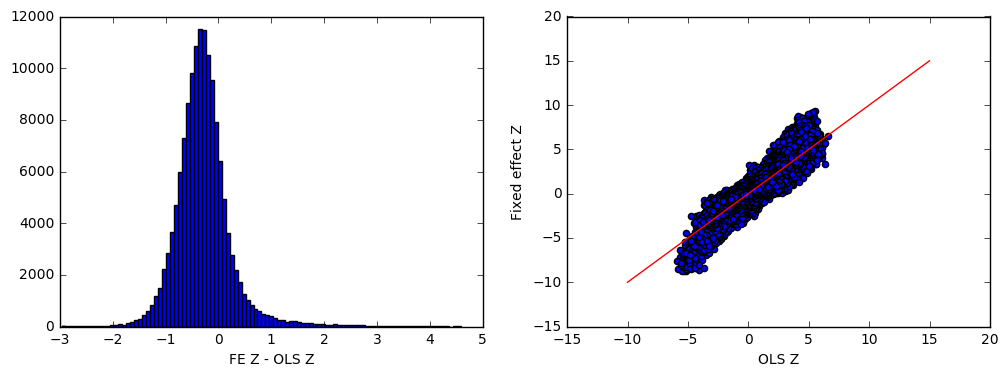

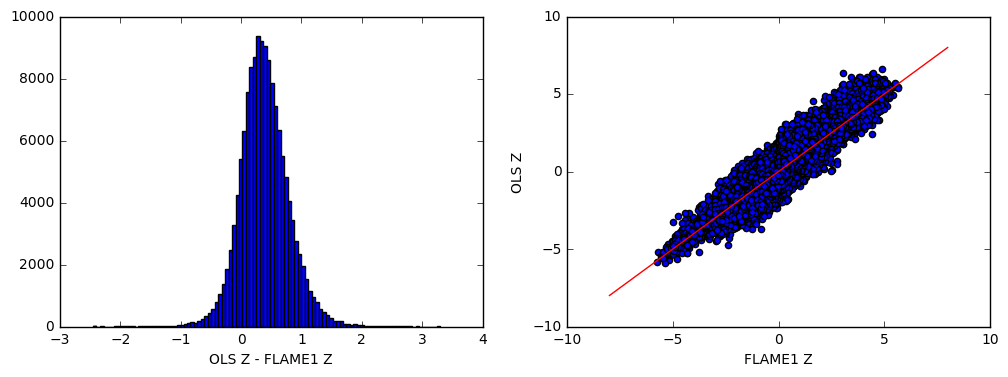

In [7]:
try:
    maskdata
except:
    zstat_fe=nibabel.load(os.path.join(results_dir,'stats_fe/zstat1.nii.gz')).get_data()
    zstat_FLAME1=nibabel.load(os.path.join(results_dir,'stats_FLAME1/zstat1.nii.gz')).get_data()
    zstat_OLS=nibabel.load(os.path.join(results_dir,'stats_OLS/zstat1.nii.gz')).get_data()
    maskdata=(zstat_fe!=0)*(zstat_FLAME1!=0)*(zstat_OLS!=0)

mindata=numpy.min([numpy.min(zstat_fe[maskdata>0]),numpy.min(zstat_OLS[maskdata>0])])
maxdata=numpy.max([numpy.max(zstat_fe[maskdata>0]),numpy.max(zstat_OLS[maskdata>0])])
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(zstat_fe[zstat_OLS>0] - zstat_OLS[zstat_OLS>0],100)
plt.xlabel('FE Z - OLS Z')
plt.subplot(122)

sc=plt.scatter(zstat_OLS[maskdata>0],zstat_fe[maskdata>0])
mindata=numpy.min([sc.get_axes().get_xlim()[0],sc.get_axes().get_ylim()[0]])
maxdata=numpy.max([sc.get_axes().get_xlim()[1],sc.get_axes().get_ylim()[1]])
plt.plot([mindata,maxdata],[mindata,maxdata],color='red')
plt.ylabel('Fixed effect Z')
plt.xlabel('OLS Z')


mindata=numpy.min([numpy.min(zstat_FLAME1[maskdata>0]),numpy.min(zstat_OLS[maskdata>0])])
maxdata=numpy.max([numpy.max(zstat_FLAME1[maskdata>0]),numpy.max(zstat_OLS[maskdata>0])])
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(zstat_OLS[zstat_OLS>0] - zstat_FLAME1[zstat_OLS>0],100)
plt.xlabel('OLS Z - FLAME1 Z')
plt.subplot(122)

sc=plt.scatter(zstat_FLAME1[maskdata>0],zstat_OLS[maskdata>0])
mindata=numpy.min([sc.get_axes().get_xlim()[0],sc.get_axes().get_ylim()[0]])
maxdata=numpy.max([sc.get_axes().get_xlim()[1],sc.get_axes().get_ylim()[1]])
plt.plot([mindata,maxdata],[mindata,maxdata],color='red')
plt.ylabel('OLS Z')
plt.xlabel('FLAME1 Z')

print ('mean absolute difference:')
print ('FE Z - OLS Z:',numpy.mean(numpy.abs(zstat_fe[maskdata>0] - zstat_OLS[maskdata>0])))
print ('OLS Z - FLAME1 Z:',numpy.mean(numpy.abs(zstat_OLS[maskdata>0] - zstat_FLAME1[maskdata>0])))

Look for outlier subjects by examining residuals

In [8]:
residfile=os.path.join(results_dir,'stats_FLAME1/res4d.nii.gz')
res4d=nibabel.load(residfile).get_data()
resdata=numpy.zeros((res4d.shape[3],numpy.sum(maskdata)))

for i in range(res4d.shape[3]):
    tmp=res4d[:,:,:,i]
    resdata[i,:]=tmp[maskdata>0]

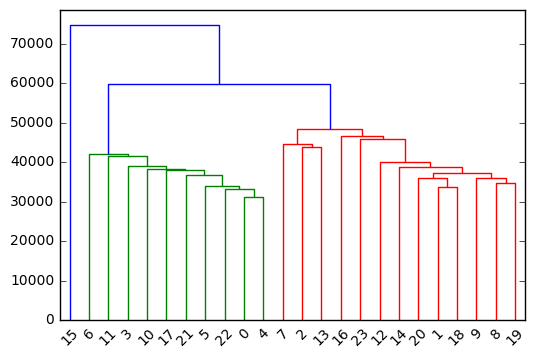

In [9]:
import scipy.cluster.hierarchy
hclust=scipy.cluster.hierarchy.ward(resdata)
cl=scipy.cluster.hierarchy.dendrogram(hclust)

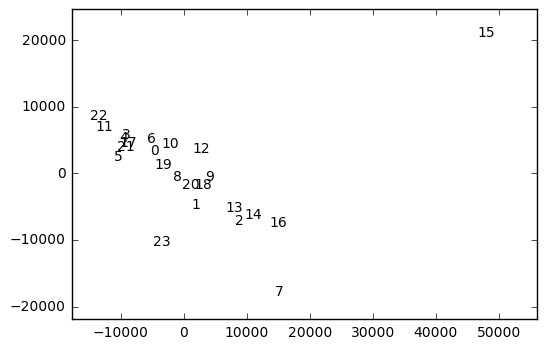

In [10]:
import sklearn.manifold
t=sklearn.manifold.TSNE(init='pca')
embedding=t.fit_transform(resdata)
plt.figure()
plt.axis([numpy.min(embedding[:,0])*1.2,numpy.max(embedding[:,0])*1.2,numpy.min(embedding[:,1])*1.2,numpy.max(embedding[:,1])*1.2])
for i in range(embedding.shape[0]):
    
    plt.text(embedding[i,0],embedding[i,1],'%d'%i)


Exercise: Load the contrast data into FSLview and identify what is different about the outlier subject.